In [40]:
import sklearn

In [41]:
sklearn.__version__

'1.3.0'

In [42]:
np.__version__

'1.24.3'

In [43]:
import scipy

In [44]:
scipy.__version__

'1.11.1'

In [46]:
pd.__version__

'2.0.3'

# Ridge, Lasso, Elastic Net

- Ridge
    - 계수 정규화(Regularization)
        - 전체 변수를 모두 유지하면서 각 변수의 계수 크기를 조정
        - 종속변수 예측에 영향을 거의 미치지 않는 변수는 0에 가까운 가중치를 주게 하여 독립변수들의 영향력을 조정
    - 위의 과정을 통해 다중공선성을 방지하면서 모델의 설명력을 최대화
    - L2-norm
    - 매개변수 alpha의 값을 조정하여 정규화 수준을 조정
        - alpha 값이 0이면 선형회귀와 동일
        - 값이 클수록 독립변수들의 영향력이 작아져 회귀선이 평균을 지나는 수평선이 됨
        
- Lasso
    - Ridge와 유사하지만 중요한 몇 개의 변수만 선택하고 나머지 변수들은 계수를 0으로 주어 변수의 영향력을 아예 없애는 점이 차이점
        - 따라서 모델을 단순하게 만들 수 있고 해석이 용이
    - L1-norm
    - 매개변수 alpha의 값을 조정하여 정규화의 강도를 조정

<img src = "./image/ridge_lasso_elastic.png">

- Elastic Net
    - Ridge와 Lasso의 최적화 지점이 다르기 때문에 두 정규화 항을 결합하여 절충한 모델
        - Ridge는 변환된 계수가 0이 될 수 없지만 Lasso는 0이 될 수 있다는 특성을 결합
        
    - Ridge와 Lasso의 혼합비율을 조절하여 성능을 최적화
        - 혼합비율이 0에 가까울수록 Ridge와 같아짐
        - 혼합비율이 1에 가까울수록 Lasso와 같아짐
        - 독립변수를 이미 잘 정제해서 중요할 것으로 판단되는 변수들만 잘 선별해둔 상태라면 Ridge의 비율을 높이는 것이 유리하고, 변수 선택 없이 주어진 독립변수를 모두 사용하는 상태라면 Lasso의 비율을 높이는 것이 유리

# P-value와 R-square 값에 따른 회귀모델 튜닝

- R-square가 높고 P-value가 0.05미만인 경우
    - 통계적으로 의미가 있으며, 모델 설명력이 높음
        - 이상적인 모형
        - 주요 인자 추출
        
- R-square가 낮고 P-value가 0.05미만인 경우
    - 통계적으로 의미가 있으나, 모델 설명력이 낮음
        - 이상치 제거
        - 비선형 회귀분석 적용
        
- R-square가 높고 P-value가 0.05보다 높은 경우
    - 통계적으로 의미가 없으나, 모델 설명력이 높음
        - 데이터 확보
        - 이상치 제거
        
- R-square가 낮고 P-value가 0.05보다 높은 경우
    - 통계적으로 의미가 없으며, 모델 설명력이 낮음
        - 새로운 변수 탐색
        - 비선형 회귀분석 적용

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn. preprocessing import PolynomialFeatures

In [32]:
# 데이터 불러오기
df = pd.read_csv("./data/kc_house_data.csv")

In [33]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [22]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


- bedrooms의 최댓값이 33인데 잘못된 값은 아닌지 확인 필요함

In [6]:
df[["price", "sqft_living", "sqft_basement", "yr_built", "zipcode"]].corr()

,price,sqft_living,sqft_basement,yr_built,zipcode
price,1.000000,0.702035,0.323816,0.054012,-0.053203
sqft_living,0.702035,1.000000,0.435043,0.318049,-0.199430
sqft_basement,0.323816,0.435043,1.000000,-0.133124,0.074845
yr_built,0.054012,0.318049,-0.133124,1.000000,-0.346869
zipcode,-0.053203,-0.199430,0.074845,-0.346869,1.000000


In [7]:
df.corr(numeric_only = True)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
price,-0.016762,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.001286,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.005160,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.012258,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.023783,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

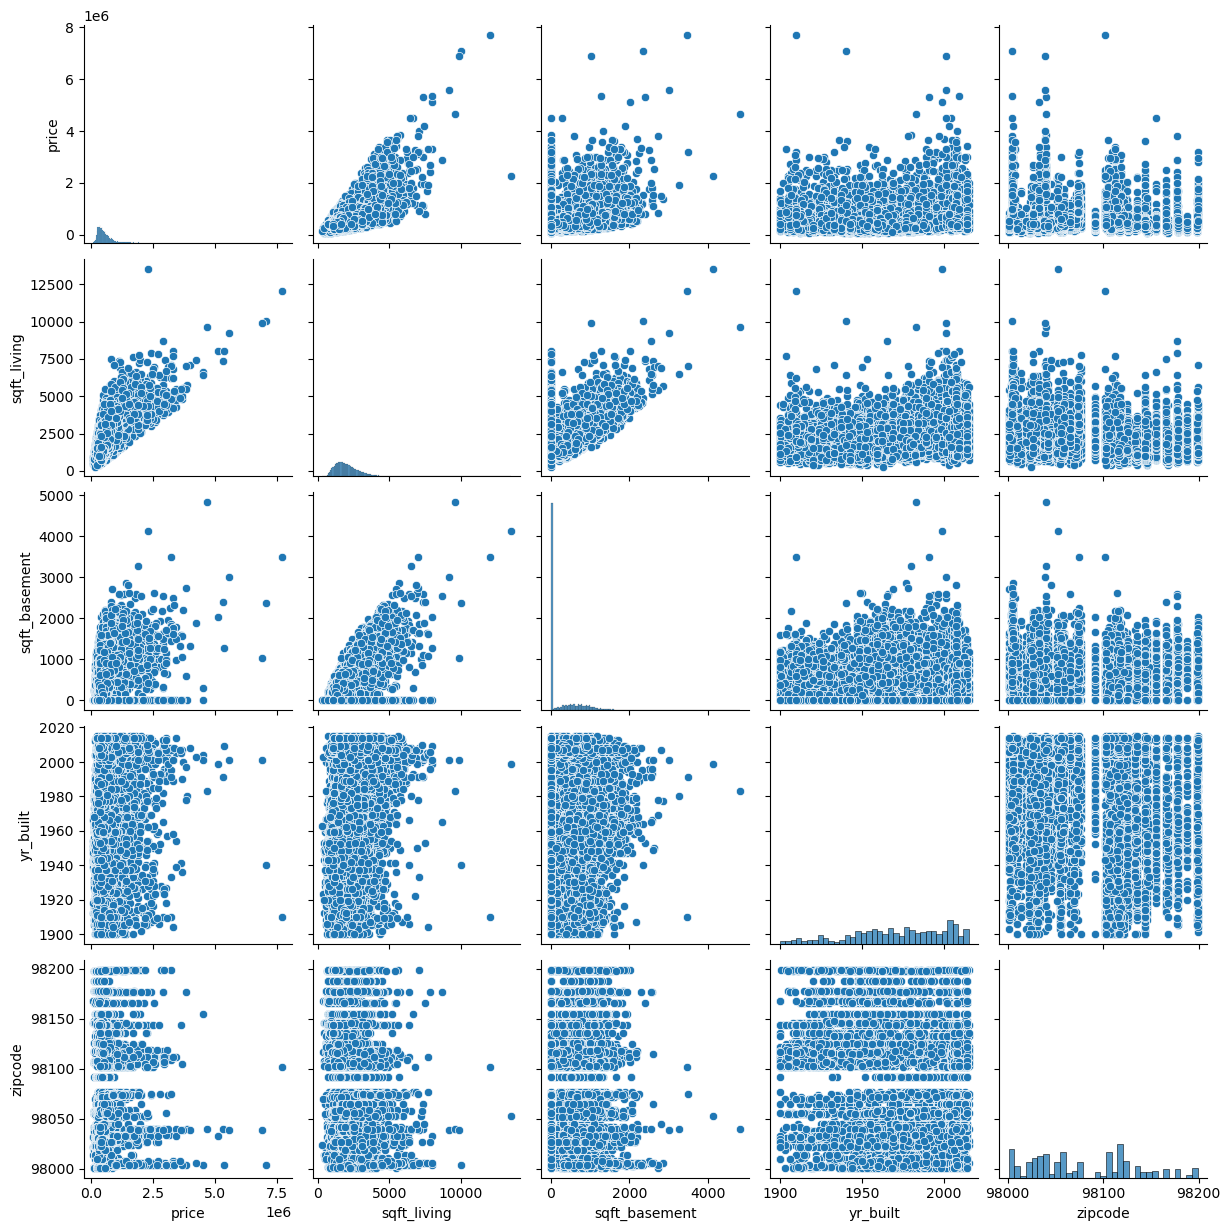

In [8]:
# 데이터 시각화하여 분포 확인
plt.figure()
sns.pairplot(df[["price", "sqft_living", "sqft_basement", "yr_built", "zipcode"]])
plt.show()

In [23]:
# 변수 선택 및 컬럼명 분여넣기 위한 컬럼 리스트 생성
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [34]:
# 독립변수, 종속변수 분리
x = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]
y = df[["price"]]

In [35]:
# 학습셋, 테스트셋 분할(7 : 3)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 11)

In [36]:
# 데이터 개수 확인
len(x_train), len(x_test)

(15129, 6484)

In [50]:
# 다중선형회귀모델
lr = LinearRegression(n_jobs = -1)
lr.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

In [51]:
y_pred = lr.predict(x_test)

In [52]:
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.6987524197735233
0.7015562522246285


In [55]:
# 모델의 상수값, 회귀계수 확인
print(lr.intercept_)
print(lr.coef_)

[6131973.08722384]
[[-3.74492798e+04  4.50138918e+04  1.14441622e+02  9.42222198e-02
   3.57565511e+03  5.88354876e+05  5.26532923e+04  2.59106679e+04
   9.30260435e+04  7.58510022e+01  3.85906199e+01 -2.65994926e+03
   1.82864724e+01 -5.74948472e+02  6.08491668e+05 -2.11870020e+05
   1.66168146e+01 -3.20262424e-01]]


In [56]:
# 자세한 모델 결과값을 확인하고 싶을 때는 OLS 패키지를 사용
ols_m = sm.OLS(y_train, sm.add_constant(x_train)).fit()
ols_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     2062.
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:38:28   Log-Likelihood:            -2.0649e+05
No. Observations:               15129   AIC:                         4.130e+05
Df Residuals:                   15111   BIC:                         4.131e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.132e+06   3.58e+06      1.714      0.087   -8.81e+05    1.31e+07
bedrooms      -3.745e+04   2254.736    -16.609      0.000   -4.19e+04    -3.3e+04
bathrooms      4.501e+04   3939.658     11.426      0.000    3.73e+04    5.27e+04
sqft_living     114.4411      2.738     41.797      0.000     109.074     119.808
sqft_lot          0.0942      0.059      1.600      0.110      -0.021       0.210
floors         3575.6551   4370.643      0.818      0.413   -4991.334    1.21e+04
waterfront     5.884e+05   2.11e+04     27.948      0.000    5.47e+05     6.3e+05
view           5.265e+04   2597.213     20.273      0.000    4.76e+04    5.77e+04
condition      2.591e+04   2866.689      9.039      0.000    2.03e+04    3.15e+04
grade          9.303e+04   2617.678     35.538      0.000    8.79e+04    9.82e+04
sqft_above       75.8516      2.743     27.657      0.000      70.476      81.227
sqft_basement    38.5912      3.225     11.967      0.000      32.270      44.912
yr_built      -2659.9493     88.792    -29.957      0.000   -2833.992   -2485.907
yr_renovated     18.2865      4.446      4.113      0.000       9.573      27.000
zipcode        -574.9485     40.090    -14.341      0.000    -653.530    -496.367
lat            6.085e+05    1.3e+04     46.702      0.000    5.83e+05    6.34e+05
long          -2.119e+05   1.59e+04    -13.287      0.000   -2.43e+05   -1.81e+05
sqft_living15    16.6168      4.185      3.970      0.000       8.413      24.821
sqft_lot15       -0.3203      0.091     -3.528      0.000      -0.498      -0.142
==============================================================================
Omnibus:                    13359.684   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1530559.437
Skew:                           3.752   Prob(JB):                         0.00
Kurtosis:                      51.700   Cond. No.                     3.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [57]:
# PolynomialFeatures 변환
poly_m = PolynomialFeatures(include_bias = False)
x_train_poly = poly_m.fit_transform(x_train)

In [58]:
x_train.shape

(15129, 18)

In [59]:
x_train_poly.shape

(15129, 189)

In [60]:
lr_poly = LinearRegression()

In [61]:
lr_poly.fit(x_train_poly, y_train)

LinearRegression()

In [62]:
# 테스트셋에 모델 적용
x_test_poly = poly_m.transform(x_test)
y_predict_poly = lr_poly.predict(x_test_poly)

In [63]:
print(lr_poly.score(x_train_poly, y_train))
print(lr_poly.score(x_test_poly, y_test))

0.8284653332513381
0.8109002207047472


In [25]:
# Ridge 모델 적용
rid = Ridge().fit(x_train_poly, y_train)
rid001 = Ridge(alpha = 0.01).fit(x_train_poly, y_train)
rid100 = Ridge(alpha = 100).fit(x_train_poly, y_train)

In [26]:
print(f"rid_train R2: {rid.score(x_train_poly, y_train)}")
print(f"rid_test R2: {rid.score(x_test_poly, y_test)}")

print(f"rid1001_train R2: {rid001.score(x_train_poly, y_train)}")
print(f"rid001_test R2: {rid001.score(x_test_poly, y_test)}")

print(f"rid100_train R2: {rid100.score(x_train_poly, y_train)}")
print(f"rid100_test R2: {rid100.score(x_test_poly, y_test)}")

rid_train R2: 0.8299777693315717
rid_test R2: 0.812094057064932
rid1001_train R2: 0.8313828158682666
rid001_test R2: 0.8141677001705143
rid100_train R2: 0.8152769258516841
rid100_test R2: 0.795585573828546


In [27]:
# Lasso 모델 적용
las = Lasso().fit(x_train_poly, y_train)
las001 = Lasso(alpha = 0.01).fit(x_train_poly, y_train)
las100 = Lasso(alpha = 100).fit(x_train_poly, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e+14, tolerance: 2.105e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e+14, tolerance: 2.105e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e+14, toleranc

In [28]:
print(f"las_train R2: {las.score(x_train_poly, y_train)}")
print(f"las_test R2: {las.score(x_test_poly, y_test)}")
print(np.sum(las.coef_ != 0))

print(f"las1001_train R2: {las001.score(x_train_poly, y_train)}")
print(f"las001_test R2: {las001.score(x_test_poly, y_test)}")
print(np.sum(las001.coef_ != 0))

print(f"las100_train R2: {las100.score(x_train_poly, y_train)}")
print(f"las100_test R2: {las100.score(x_test_poly, y_test)}")
print(np.sum(las100.coef_ != 0))

las_train R2: 0.7888882278420138
las_test R2: 0.7658851462233482
189
las1001_train R2: 0.7888908344930209
las001_test R2: 0.765892451092385
189
las100_train R2: 0.7887148187839539
las100_test R2: 0.7667716678570508
176


- Elastic Net은 기본적으로 alpha와 l1_ratio 를 설정
    - 여기서 alpha는 Ridge와 Lasso의 alpha와는 다름
    - ElasticNet의 정규화는 Ridge와 Lasso를 합친 것이므로 alpha L1 + beta L2 임
    - l1_ratio 는 0에서 1의 값을 가지며 Lasso 모델의 비중을 나타냄
        - l1_ration가 1이면 Lasso와 같고 0이면 Ridge와 같은 모델이 됨

In [29]:
# ElasticNet 모델 적용
elast = ElasticNet().fit(x_train_poly, y_train)
elast001 = ElasticNet(alpha = 0.01, l1_ratio = 0).fit(x_train_poly, y_train)
elast100 = ElasticNet(alpha = 100, l1_ratio = 1).fit(x_train_poly, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e+14, tolerance: 2.105e+11
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e+14, tolerance: 2.105e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

In [30]:
print(f"elast_train R2: {elast.score(x_train_poly, y_train)}")
print(f"elast_test R2: {elast.score(x_test_poly, y_test)}")
print(np.sum(elast.coef_ != 0))

print(f"elast1001_train R2: {elast001.score(x_train_poly, y_train)}")
print(f"elast001_test R2: {elast001.score(x_test_poly, y_test)}")
print(np.sum(elast001.coef_ != 0))

print(f"elast100_train R2: {elast100.score(x_train_poly, y_train)}")
print(f"elast100_test R2: {elast100.score(x_test_poly, y_test)}")
print(np.sum(elast100.coef_ != 0))

elast_train R2: 0.7873505757071597
elast_test R2: 0.7672193067011771
189
elast1001_train R2: 0.7885087456287267
elast001_test R2: 0.7667560350987226
189
elast100_train R2: 0.7887148187839539
elast100_test R2: 0.7667716678570508
176
